# Lab Assignment Three: Extending Logistic Regression 

Group Members: Christina DeSantiago, Estefy Fiallos, Kaiying Li, Tianyu Li

In this lab, you will compare the performance of logistic regression optimization programmed in scikit-learn and via your own implementation. You will also modify the optimization procedure for logistic regression. 



**Preparation and Overview (30 points total)**

[20 points] Explain the task and what business-case or use-case it is designed to solve (or designed to investigate). Detail exactly what the classification task is and what parties would be interested in the results. For example, would the model be deployed or use mostly for offline analysis? 
-----------------------------------------------------------------------------------------------------------
For this lab, we chose the same dataset as lab one: Ames Housing Data. Our task is to classify houses into one of three price ranges based on the various attributes of the property (# of bedrooms, square footage, year built, etc). Our price ranges are labeled as 0, 1, 2 to represent a low, medium, and high price.

For the buyers, it will be convenient for them to narrow down the house choices within their budget range by selecting the number of bedrooms and bathrooms, garage types and other features when they are in the house market.

On the other hand, for sellers such as real estate or construction company, it is crucial to understand which type of houses or floor plan are more desirable in the market. Predicting the sales prices of different type of houses not only helps them optimize their asset acquisition or construction plan, it also leads to quicker asset turn over and smooth sales process. Ultimately a greater profit is achieved. It would also be important for a real estate company to predict the price range of a house specifically for meeting quotas. Sales representatives often have quotas to meet each business quarter for their sales. Understanding the predicted price range of a property will allow a sales rep to push more towards certain kinds of properties in order to meet these quotas. 

We envision that our model would be deployed, so that it provides predictions in real time and it's continually updated with new data. We would want our classification model to be used specifically for sellers. Therefore, it's important that the model be continually updated since housing prices change each year. If we were to use an offline model, our prediction of housing prices in the future would solely be based on the historical data. This is not good statistical practice for our data set because we only have information on the properties sold during 2006-2010. If we tried to use this offline model to predict the price range for a house currently on sale in Ames, Iowa we would be extrapolating for our classification. Also, using an offline model means that our method could quickly become irrelevant. We might be able to make accurate predictions for the test data but as time goes on and the market changes the perform will go down. For these reasons, we believe our classification task would be better as a deployed model and will be more relevant to sellers as such.





## **[5 points] (mostly the same processes as from previous labs) Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). **

We used our same dataset from lab one with a subset of 8 attributes: Gr Liv Area = Above ground living area (continuous), SalePrice = Sales price in dollars (continuous), Year built (discrete), Full Bath = number of full bathrooms (discrete), Bedroom AbvGr = number of bedrooms above ground (discrete), Garage Type (nominal), Lot frontage (continuous), Lot Area (continuous).

We changed the Garage Type variable to be one-hot encoded, creating 7 new dummy variables for our data set. We used the same method of imputing missing values in Lot Frontage based on Lot Area. We also transformed our SalePrice variable into a Price_Range variable. Instead of having a continuous response variable, we now have a categorical response with 3 different levels of pricing so we can use multi level classification. We used the distribution of SalePrice, which we investigated in lab one, to determine how to split the prices into ranges. A house with sale price less than 130,000 dollars is assigned to the lowest price range "0" and houses with sale price above 210,000 dollars are assigned to the highest price range "2".

Our final data set has 15 variables: 14 predictors (7 dummy variables for Garage Type + 7 previously defined variables) and 1 target variable.



In [0]:
#import data

#we import the dataset from the source given above
import pandas as pd
df2=pd.read_csv("https://ww2.amstat.org/publications/jse/v19n3/decock/AmesHousing.txt", sep="\t")
df2.head()

#make a subset of the dataset only with the variables we are interested in
to_keep=['Lot Frontage','Lot Area','Year Built', 'Gr Liv Area','Full Bath', 'Bedroom AbvGr','Garage Type', 'SalePrice']
sub = df2[to_keep].copy()

#check the data types and missing values
sub.info()

In [0]:
#Change NA values in 'Garage Type' to No_Garage (since NA is described as no garage in data documentation)
sub['Garage Type'].fillna(value='No_Garage', inplace= True)
sub.info()

In [0]:
#one hot encoding for the Garage Type variable
tmp = pd.get_dummies(sub['Garage Type'])
result = pd.concat([sub, tmp],axis=1, join_axes=[sub.index])
del result['Garage Type'] #delete since we have the dummy variables now
result.head()

,Lot Frontage,Lot Area,Year Built,Gr Liv Area,Full Bath,Bedroom AbvGr,SalePrice,2Types,Attchd,Basment,BuiltIn,CarPort,Detchd,No_Garage
0,141.0,31770,1960,1656,1,3,215000,0,1,0,0,0,0,0
1,80.0,11622,1961,896,1,2,105000,0,1,0,0,0,0,0
2,81.0,14267,1958,1329,1,3,172000,0,1,0,0,0,0,0
3,93.0,11160,1968,2110,2,3,244000,0,1,0,0,0,0,0
4,74.0,13830,1997,1629,2,3,189900,0,1,0,0,0,0,0


In [0]:
#Imputation of Lot Frontage
#Breaking up 'Lot Area' into intervals
result['Lot_Area_Ranges']= pd.cut(result['Lot Area'], [0, 10000, 20000, 30000, 250000])

result_grouped = result.groupby(by=['Lot_Area_Ranges'])

#Fill missing values with mean within 'Lot Area' intervals
func = lambda grp: grp.fillna(grp.mean())
result_imputed= result_grouped.transform(func)

# fill any deleted columns
col_deleted = list( set(result.columns) - set(result_imputed.columns)) # in case the mean operation deleted columns
result_imputed[col_deleted] = result[col_deleted]

result_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 15 columns):
Lot Frontage       2930 non-null float64
Lot Area           2930 non-null int64
Year Built         2930 non-null int64
Gr Liv Area        2930 non-null int64
Full Bath          2930 non-null int64
Bedroom AbvGr      2930 non-null int64
SalePrice          2930 non-null int64
2Types             2930 non-null uint8
Attchd             2930 non-null uint8
Basment            2930 non-null uint8
BuiltIn            2930 non-null uint8
CarPort            2930 non-null uint8
Detchd             2930 non-null uint8
No_Garage          2930 non-null uint8
Lot_Area_Ranges    2930 non-null category
dtypes: category(1), float64(1), int64(6), uint8(7)
memory usage: 183.3 KB


In [0]:
#get rid of the "Lot Area Range" variable because we don't need it in prediction model
result=result_imputed.copy()
del result['Lot_Area_Ranges']

In [0]:
#Break Sales price into 3 classes for prediction
result['Price_Range']=pd.cut(result["SalePrice"], [0,130000,210000,800000],labels=[0,1,2])
#0=low, 1=mid, 2= high
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 15 columns):
Lot Frontage     2930 non-null float64
Lot Area         2930 non-null int64
Year Built       2930 non-null int64
Gr Liv Area      2930 non-null int64
Full Bath        2930 non-null int64
Bedroom AbvGr    2930 non-null int64
SalePrice        2930 non-null int64
2Types           2930 non-null uint8
Attchd           2930 non-null uint8
Basment          2930 non-null uint8
BuiltIn          2930 non-null uint8
CarPort          2930 non-null uint8
Detchd           2930 non-null uint8
No_Garage        2930 non-null uint8
Price_Range      2930 non-null category
dtypes: category(1), float64(1), int64(6), uint8(7)
memory usage: 183.3 KB


Text(0.5,1,'Distribution of Price Range')

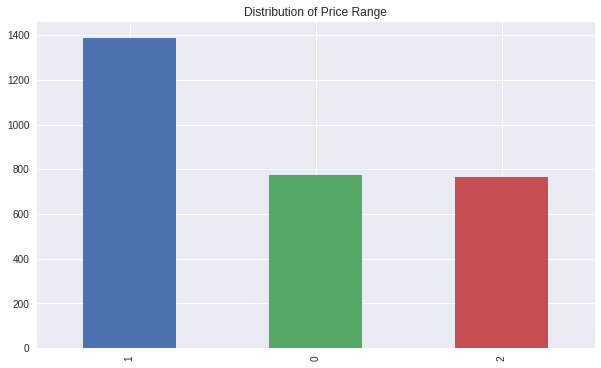

In [0]:
#visualize Price Range with bar chart
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
result['Price_Range'].value_counts().plot(kind='bar')
plt.title('Distribution of Price Range')

##[5 points] Divide you data into training and testing data using an 80% training and 20% testing split. Use the cross validation modules that are part of scikit-learn. Argue "for" or "against" splitting your data using an 80/20 split. That is, why is the 80/20 split appropriate (or not) for your dataset?  

Having 80% split into the training set is good for our data set since we don't have that many observations to begin with. Our data set has 2930 observations, so the split will be: 2344 observations to train and 586 observations to test. We don't want to have too few observations in our training model or too few to test so we will keep to the 80/20 split. Also, from the visualization of Price_Range in the two data sets, we see that the same proportion of classes are represented in each set. We have 50% of the observations from the middle price range and 25% each from the low and high price ranges. This is good because if the 80/20 split resulted in extreme class imbalances in the two sets, we would not want to use that for training and testing. Lastly, our data is not of a time series kind. Even though we have a Year built attribute, the other attributes are not dependent on this measure of time. So randomly splitting our data into 2 sets does not distort any of the relationships between the predictors and our response, like it would if our data was time dependent.

In [0]:
from sklearn.model_selection import ShuffleSplit

df=result.copy()
del df['SalePrice']
# we want to predict the X and y data as follows:
if 'Price_Range' in df:
    y = df['Price_Range'].values # get the labels we want
    del df['Price_Range'] # get rid of the class label
    X = df.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    

In [0]:
y

[2, 0, 1, 2, 1, ..., 1, 1, 1, 1, 1]
Length: 2930
Categories (3, int64): [0 < 1 < 2]

In [0]:
X.shape

(2930, 13)

In [0]:
import random

#split into training and test set
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations, test_size  = 0.2, random_state=10)
print(cv_object)

for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
print("Length of Training set = %d" % (len(X_train)))   
print("Length of Test set = %d" % (len(X_test)))   


ShuffleSplit(n_splits=3, random_state=10, test_size=0.2, train_size=None)
Length of Training set = 2344
Length of Test set = 586


Text(0.5,1,'Distribution of Price Range in Test set')

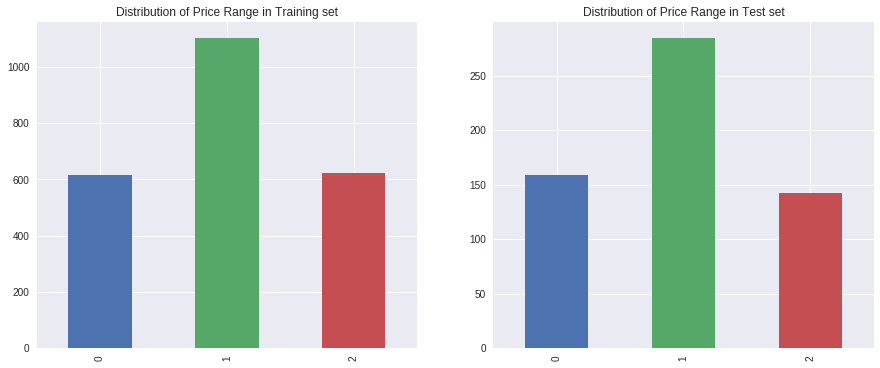

In [0]:
#visualize Price Range in test/training sets with bar chart
import matplotlib.pyplot as plt
plt.subplots(figsize=(15,6))
plt.subplot(1,2,1)
y_train.value_counts().plot(kind='bar')
plt.title('Distribution of Price Range in Training set')

plt.subplot(1,2,2)
y_test.value_counts().plot(kind='bar')
plt.title('Distribution of Price Range in Test set')

#**Modeling (50 points total)**

###**The implementation of logistic regression must be written only from the examples given to you by the instructor. No credit will be assigned to teams that copy implementations from another source, regardless of if the code is properly cited.** 

###**[20 points] Create a custom, one-versus-all logistic regression classifier using numpy and scipy to optimize. Use object oriented conventions identical to scikit-learn. You should start with the template developed by the instructor in the course. You should add the following functionality to the logistic regression classifier: Ability to choose optimization technique when class is instantiated: either steepest descent, stochastic gradient descent, or Newton's method. Update the gradient calculation to include a customizable regularization term (either using no regularization, L1 regularization, L2 regularization, or both L1 and L2 regularization). Associate a cost with the regularization term, "C", that can be adjusted when the class is instantiated.**


In [0]:
#First add functionalities to the binary logistic regression model
%%time
import numpy as np
from numpy.linalg import pinv
from sklearn.metrics import accuracy_score
from scipy.special import expit
from scipy.optimize import minimize_scalar
import copy

# method options are SD (steepest descent), SGD (stochastic gradient descent), or NEWTON (Newton's method)
# reg options are L1 and L2
class BinaryLogisticRegression:
    def __init__(self, eta, method, reg = None, iterations=20, C=0.001):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.method = method.upper() if method else None
        self.reg = reg.upper() if reg else None
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'
        
    # convenience, private:
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    # gradient calculation
    def _get_gradient(self,X,y):
        idx = int(np.random.rand()*len(y)) # grab random instance
        if self.method=="SD": 
          ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
          gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        elif self.method == "SGD": 
          ydiff = y[idx]-self.predict_proba(X[idx],add_bias=False) # get y difference (now scalar)
          gradient = X[idx] * ydiff[:,np.newaxis] # make ydiff a column vector and multiply through
        elif self.method == "NEWTON":
          g = self.predict_proba(X,add_bias=False).ravel() # get sigmoid value for all classes
          hessian = X.T @ np.diag(g*(1-g)) @ X - 2 * self.C # calculate the hessian

          ydiff = y-g # get y difference
          gradient = np.sum(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
          gradient = gradient.reshape(self.w_.shape)
                  
          
        gradient = gradient.reshape(self.w_.shape)
        
        if self.reg == "L2":
          gradient[1:] += -2 * self.w_[1:] * self.C
        elif self.reg == "L1" and self.method != "NEWTON":
          gradient[1:] += np.sign(self.w_[1:]) * self.C 
        
        return gradient if self.method != "NEWTON" else pinv(hessian) @ gradient
    
    
    # public:
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
    
    
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate 



CPU times: user 78 µs, sys: 13 µs, total: 91 µs
Wall time: 97.3 µs


In [0]:
#Create one vs all logistic regression classifier from binary model

class LogisticRegression:
    def __init__(self, eta, method, reg = None, iterations=20, C=0.001):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.method = method.upper() if method else None
        self.reg = reg.upper() if reg else None
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.unique(y) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = [] # will fill this array with binary classifiers
        
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = y==yval # create a binary problem
            # train the binary classifier for this class
            blr = BinaryLogisticRegression(self.eta,self.method,self.reg,self.iters,self.C)
            blr.fit(X,y_binary)
            # add the trained classifier to the list
            self.classifiers_.append(blr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for blr in self.classifiers_:
            probs.append(blr.predict_proba(X)) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return np.argmax(self.predict_proba(X),axis=1) # take argmax along row
    


Testing if our classifier works for a few different methods:

In [0]:
%%time
lr = LogisticRegression(eta=0.1, method="SD", iterations=500)
lr.fit(X_train,y_train)
#print(lr)

yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

Accuracy of:  0.4351535836177474
CPU times: user 463 ms, sys: 289 ms, total: 751 ms
Wall time: 383 ms


In [0]:
%%time
lr = LogisticRegression(eta=0.1, method="SGD", iterations=500)
lr.fit(X_train,y_train)
#print(lr)

yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

Accuracy of:  0.49829351535836175
CPU times: user 21.6 ms, sys: 2.61 ms, total: 24.2 ms
Wall time: 28 ms


In [0]:
%%time
lr = LogisticRegression(eta=0.1, method="NEWTON", iterations=30)
lr.fit(X_train,y_train)
#print(lr)

yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

Accuracy of:  0.7389078498293515
CPU times: user 4.66 s, sys: 1.05 s, total: 5.71 s
Wall time: 2.87 s


###[15 points] Train your classifier to achieve good generalization performance. That is, adjust the optimization technique and the value of the regularization term "C" to achieve the best performance on your test set. Visualize the performance of the classifier versus the parameters you investigated. Is your method of selecting parameters justified? That is, do you think there is any "data snooping" involved with this method of selecting parameters?


Just from the few tests of our classifer above, it appears that the "Newton" method performs the best since it has the highest accuracy. We will first try to optimize the Newton method using L2 regularization for the best value of C.

In [0]:
#see how the accuracy changes when adjusting C for one type of technique
%%time
import numpy as np
c1=np.arange(0,1,0.01)
acc1=[]
d1=[]
for i in range(len(c1)):
  key=("Newton,L2")
  lr = LogisticRegression(eta=0.1, method="NEWTON", reg="L2", iterations=30,C=c1[i])
  lr.fit(X_train,y_train)
  yhat = lr.predict(X_test)
  accscore=accuracy_score(y_test,yhat)
  acc1.append(accscore)
  d1.append(key)

CPU times: user 8min 50s, sys: 1min 23s, total: 10min 13s
Wall time: 5min 7s


Text(0.5,1,'Accuracy vs C for Newton, L2 technique')

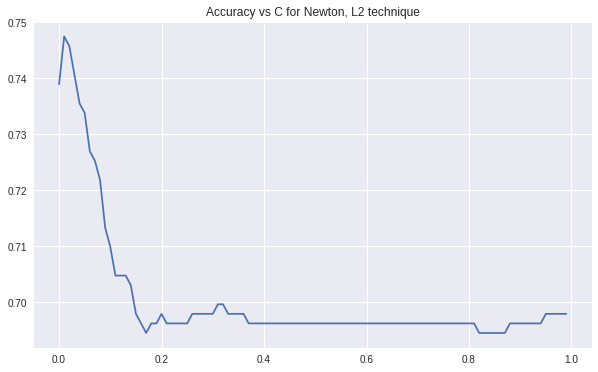

In [0]:
#to visualize the change
#convert acc to array
acc1=np.asarray(acc1)

# make dataframe
import pandas as pd
df=pd.DataFrame({'C':c1, 'Accuracy':acc1})

#plot C vs. Accuracy
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot('C','Accuracy',data=df)
plt.title("Accuracy vs C for Newton, L2 technique")

In [0]:
#highest accuracy
print(acc1.max())
#C that gives this accuracy
idx=np.where(acc1 ==acc1.max())
print(c1[idx])

0.7474402730375427
[0.01]


In [0]:
#manually save our best value of C
bestC=0.01

After adjusting the C value 100 times and comparing the accuracy at that level, it appears the optimal C value is at 0.01.
We also wanted to see if adjusting our eta will affect the accuracy. 

In [0]:
#see how the accuracy changes when adjusting eta for one type of technique
%%time
import numpy as np
e=np.arange(0,1,0.01)
acc=[]
for i in range(len(e)):
  lr = LogisticRegression(eta=e[i], method="NEWTON", reg="L2", iterations=30, C=bestC)
  lr.fit(X_train,y_train)
  yhat = lr.predict(X_test)
  accscore=accuracy_score(y_test,yhat)
  acc.append(accscore)

CPU times: user 8min 48s, sys: 1min 24s, total: 10min 12s
Wall time: 5min 7s


Text(0.5,1,'Accuracy vs Eta for Newton, L2 technique')

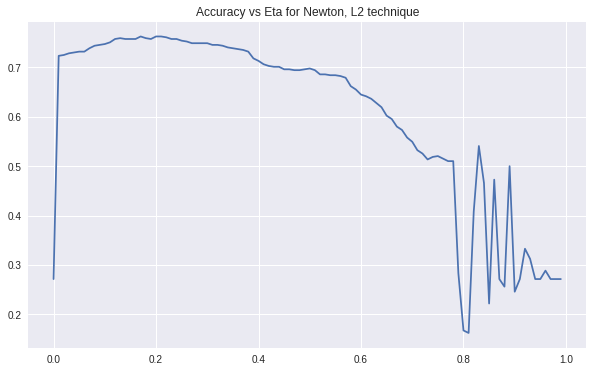

In [0]:
# to visualize the change
#convert acc to array
acc=np.asarray(acc)

# make dataframe
import pandas as pd
df=pd.DataFrame({'Eta':e, 'Accuracy':acc})

#plot Eta vs. Accuracy
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot('Eta','Accuracy',data=df)
plt.title("Accuracy vs Eta for Newton, L2 technique")

In [0]:
#highest accuracy
print(acc.max())
#C that gives this accuracy
idx=np.where(acc ==acc.max())
print(e[idx])

0.7627986348122867
[0.17 0.2  0.21]


Several values of eta achieved a high accuracy score. 

We suspected that the Newton method would give us the highest accuracy, but we will check if that is true by optimizing for all other methods as well and then comparing the accuracy.

In [0]:
#extend the optimization for all techniques
%%time
import numpy as np
c=np.arange(0,1,0.01)
methods=["SD","SGD"]
regs=["L1","L2"]
key=[]  # to make the descriptor
cs=[]  # will hold what the c value is
acc=[]  # will hold the accuracy score
d=[]   # will hold the descriptor of method & reg type
for method in methods:
  for reg in regs:
    key=(method + "," + reg)
    for i in range(len(c)):
      lr = LogisticRegression(eta=0.1, method=method, reg=reg, iterations=500,C=c[i])
      lr.fit(X_train,y_train)
      yhat = lr.predict(X_test)
      accscore=accuracy_score(y_test,yhat)
      acc.append(accscore)  #append the accuracy score
      d.append(key)         #append the descriptor
      cs.append(c[i])       #append the c value

CPU times: user 2min 15s, sys: 1min 15s, total: 3min 31s
Wall time: 1min 48s


In [0]:
#create a data frame with all methods to compare accuracy
c_all=np.hstack([c1,cs])
d_all=np.hstack([d1,d])
acc_all=np.hstack([acc1,acc])

import pandas as pd
df_all=pd.DataFrame({'method':d_all,'Accuracy':acc_all,'c':c_all})

In [0]:
pivot=df_all.pivot(index="c",columns="method",values="Accuracy")
#print(pivot)
#source: https://stackoverflow.com/questions/44480226/plotting-heatmap-for-3-columns-in-python-with-seaborn
import seaborn as sns
plt.figure(figsize=(8,8))
ax= sns.heatmap(pivot, annot=False, vmax=.8,yticklabels=10)
plt.show()

After comparing the Newton, L2 method with our other techniques, we can confirm that it indeed is the best performing method. For Newton, L2 we always had an accuracy above 0.7 whereas for the other methods we rarely achieved an accuracy this high. Whenever we used L2 regularization with either steepest descent or stochastic gradient descent, accuracy was mostly around 0.3 for majority of the C values. When using L1 for these two methods, accuracy with higher, normally around 0.5 for majority of the C values. It is interesting to see that for steepest descent using L2 regularization, the accuracy was always above 0.5 whenever C was greater than 0.8

We believe that this method of selecting parameters could be considered data snooping.

A definition of data snooping by Halbert White is the following: "Data snooping occurs when a given set of data is used more than once for purposes of inference or model selection. When such data reuse occurs, there is always the possibility that any satisfactory results obtained may simply be due to chance rather than to any merit inherent in the method yielding the results." 

In this case we're using the test set to both optimize our model and to report the accuracy of our model. However, a better performing model does not necessarily mean that the model will work better in general, rather it is affected by the specific data patterns in the test set. In that sense, our selection of parameters based on the model performance in the test set is not justified since the improvement in the model may simply be due to chance. In fact, if we run our optimization of C over again with a different 80/20 data split, we would return a different optimal C each time.

Source: https://www.ssc.wisc.edu/~bhansen/718/White2000.pdf

###[15 points] Compare the performance of your "best" logistic regression optimization procedure to the procedure used in scikit-learn. Visualize the performance differences in terms of training time and classification performance. Discuss the results. 

In [0]:
import time

sk_start=time.time()
from sklearn.linear_model import LogisticRegression as SKLogisticRegression

lr_sk = SKLogisticRegression(penalty="l2", C=bestC, solver="newton-cg", max_iter=30) 

lr_sk.fit(X_train,y_train)
yhat_sk = lr_sk.predict(X_test)
sk_end=time.time()

#print(np.hstack((lr_sk.intercept_[:,np.newaxis],lr_sk.coef_)))


/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


In [0]:
#our method
cust_start=time.time()
lr =  LogisticRegression(eta=0.2, method="NEWTON", reg="L2", iterations=30,C=bestC) 
lr.fit(X_train,y_train)
yhat_lr = lr.predict(X_test)
cust_end=time.time()

In [0]:
#compare accuracy of methods
print('Accuracy of scikit-learn: ', accuracy_score(y_test,yhat_sk))
print('Accuracy of custom method: ', accuracy_score(y_test,yhat_lr))

Accuracy of scikit-learn:  0.6672354948805461
Accuracy of custom method:  0.7627986348122867


Text(0.5,1,'Custom method vs SKLearn')

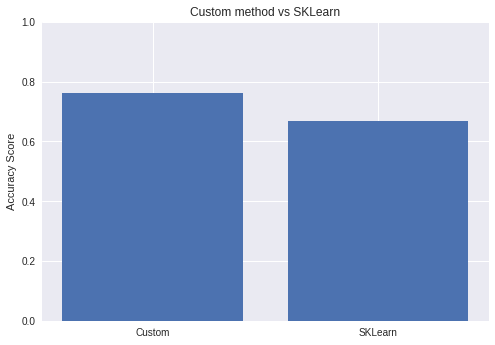

In [0]:
#visualize difference in accuracy scores
method = ('Custom', 'SKLearn')
accuracy = (accuracy_score(y_test,yhat_lr), accuracy_score(y_test,yhat_sk))

plt.bar(method, accuracy)
plt.ylabel("Accuracy Score")
plt.ylim(0, 1)
plt.title('Custom method vs SKLearn')

Text(0.5,1,'Custom method vs SKLearn')

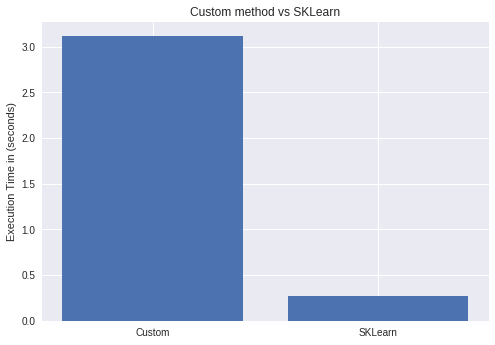

In [0]:
#comparison of execution time
method = ('Custom', 'SKLearn')
times = ((cust_end-cust_start), (sk_end-sk_start))

plt.bar(method, times)
plt.ylabel("Execution Time in (seconds)")
plt.title('Custom method vs SKLearn')


In [0]:
from sklearn import metrics
cm=metrics.confusion_matrix(yhat_sk,yhat_lr)
print(cm)
print('Ratio of Matches: ',accuracy_score(yhat_sk,yhat_lr))

[[ 95  17   0]
 [ 52 256  45]
 [  3  15 103]]
Ratio of Matches:  0.7747440273037542


In [0]:
#normalize the confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
diag=cm_norm.diagonal()
print(cm_norm)


[[0.84821429 0.15178571 0.        ]
 [0.14730878 0.72521246 0.12747875]
 [0.02479339 0.12396694 0.85123967]]


In [0]:
class_name = y.unique()
class_name = np.sort(np.asarray(class_name))


[[0.84821429 0.15178571 0.        ]
 [0.14730878 0.72521246 0.12747875]
 [0.02479339 0.12396694 0.85123967]]


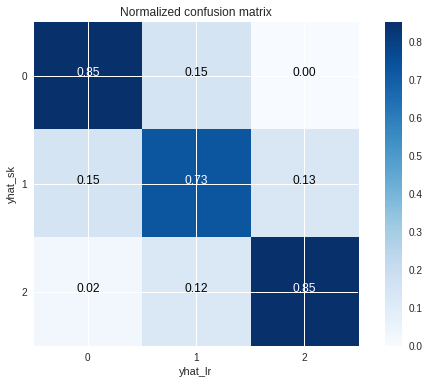

In [0]:
import itertools
import matplotlib.pyplot as plt
#source:http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-download-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',ylab='True label',xlab='Predicted label',
                          cmap=plt.cm.Blues):

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() /2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j],fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel(ylab)
    plt.xlabel(xlab)
    plt.tight_layout()



# Plot normalized confusion matrix

plot_confusion_matrix(cm_norm, classes=class_name,
                      title='Normalized confusion matrix',xlab="yhat_lr",ylab="yhat_sk")

plt.show()

In [0]:
print(diag)

[0.75308642 0.63846154 0.79130435]


Based on the best optimization methods and "C" we choose in the last part, the results between the scikit-learn method and customized method are different.
In terms of the CPU time, the procedure used in scikit-learn is faster than the function we cusomized. The accuracy of the customized method is better than the scikit-learn.
We use the confusion matrix to compare the classification performance of two methods. We draw the heatmap to visualize the confusion matrix. The ratio of concordant results from these two methods is 70%. The diagonal elements of the normalized confusion matrix are the percent of matched predictions between two methods by class. For example, 85% of the prediction by customized function, which is in class 0, matches the class 0 prediction by scikit-learn. 

##Deployment (10 points total)**

###Which implementation of logistic regression would you advise be used in a deployed machine learning model, your implementation or scikit-learn (or other third party)? Why?



We would recommend the scikit-learn logistic regression. Although our implementation achieved a higher accuracy score than scikit-learn (73% vs 64%)**, these accuracy scores are specific to this data. In fact, we got different accuracy scores everytime we ran our code. So, it might be that scikit-learn outperforms our custom method on a different data set, and the accuracy scores aren't different enough that we would base our recommendation on that alone.

**Note: we achieved these accuracy scores on previous runs, however, in our last runs we received the warning that the sklearn implementation did not converge. Our recommendation is based on the assumption that sklearn converges. 

Scikit-learn's execution time was about 10 times faster than our method's. This is a great advantage when analyzing large datasets. Therefore, we'd advise that scikit-learn be used in a deployed machine learning model. 


# **Exceptional Work (10 points total)**

###You have free reign to provide additional analyses. One idea: Update the code to use either "one-versus-all" or "one-versus-one" extensions of binary to multi-class classification. One idea (required for 7000 level students): Implement an optimization technique for logistic regression using mean square error as your objective function (instead of binary entropy). Your solution should be able to solve the binary logistic regression problem in one gradient update step. 

In [0]:
%%time
# from last time, our logistic regression algorithm is given by (including everything we previously had):
class ABinaryLogisticRegression:
    def __init__(self, eta, iterations=200):
        self.eta = eta
        self.iters = iterations
        # internally we will store the weights as self.w_ to keep with sklearn conventions
        
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'
        
    # convenience, private:
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return 1/(1+np.exp(-theta))
    
    # vectorized gradient calculation with regularization using L2 Norm
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:]  #* self.C
        
        return gradient
    
    # public:
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
    
    
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate 

CPU times: user 57 µs, sys: 0 ns, total: 57 µs
Wall time: 62 µs


In [0]:
%%time
from numpy.linalg import pinv
class HessianBinaryLogisticRegression(ABinaryLogisticRegression):
    # just overwrite gradient function
    def _get_gradient(self,X,y):
        g = self.predict_proba(X,add_bias=False).ravel() # get sigmoid value for all classes
        hessian = 2 * X.T @ X #- 2 * self.C # calculate the hessian

        ydiff = y-g # get y difference
        gradient = np.sum(2 * X * ydiff[:,np.newaxis], axis=0)
        # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:] #* self.C
        
        return pinv(hessian) @ gradient
       
hblr = HessianBinaryLogisticRegression(eta=0.1,iterations=10)#note that we need only a few iterations here


CPU times: user 54 µs, sys: 10 µs, total: 64 µs
Wall time: 69.6 µs


In [0]:
class MultiClassLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.0001):
        self.eta = eta
        self.iters = iterations
        self.classifiers_ = []
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.sort(np.unique(y)) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = []
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = y==yval # create a binary problem
            # train the binary classifier for this class
            hblr = HessianBinaryLogisticRegression(self.eta,self.iters)
            hblr.fit(X,y_binary)
            #print(accuracy(y_binary,hblr.predict(X)))
            # add the trained classifier to the list
            self.classifiers_.append(hblr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for hblr in self.classifiers_:
            probs.append(hblr.predict_proba(X).reshape((len(X),1))) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return np.argmax(self.predict_proba(X),axis=1) # take argmax along row
    
lr = MultiClassLogisticRegression(eta=0.1,iterations=1)

lr.fit(X_train,y_train)
print(lr)

yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

MultiClass Logistic Regression Object with coefficients:
[[ 8.30269939e-01 -9.23149223e-05 -1.33078758e-07 -4.59936879e-04
  -2.04573149e-05 -7.79340074e-03 -1.19769003e-03  1.04840658e-01
   1.00273029e-01  1.07955331e-01  1.14304666e-01  1.51687173e-01
   1.13488949e-01  1.37720140e-01]
 [-1.05994135e-01 -2.59008923e-05 -2.01773101e-07  5.84598188e-05
  -2.81628092e-05  5.75403554e-03  1.17295258e-02  1.33327629e-02
  -2.33666578e-03 -1.64640857e-03 -1.77104986e-02 -4.28354515e-02
  -1.44102322e-02 -4.03876428e-02]
 [-7.68025804e-01  1.18215815e-04  3.34851859e-07  4.01477060e-04
   4.86201242e-05  2.03936520e-03 -1.05318358e-02 -1.24423421e-01
  -1.04186364e-01 -1.12558923e-01 -1.02844168e-01 -1.15101722e-01
  -1.05328717e-01 -1.03582498e-01]]
Accuracy of:  0.7235494880546075
